In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from helpers import util
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-12 13:12:27,234 INFO: Initializing external client
2025-11-12 13:12:27,235 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-12 13:12:28,604 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272014


In [3]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [4]:
# Select features for training data. todo check if city should be here
base_features = air_quality_fg.select(['pm25', 'city', 'date']).join(weather_fg.select_features(), on=['city'])
lagged_features = air_quality_fg.select(['pm25', 'lagged_1', 'lagged_2', 'lagged_3', 'city', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-12 13:12:31,310 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] as features for the query.To include primary key and event time use `select_all`.
2025-11-12 13:12:31,311 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] as features for the query.To include primary key and event time use `select_all`.


In [5]:
base_feature_view = fs.get_or_create_feature_view(
    name='air_quality_base_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=base_features,
)

lagged_feature_view = fs.get_or_create_feature_view(
    name='air_quality_lagged_fv',
    description="features with air quality as the target (including lagged air quality)",
    version=1,
    labels=['pm25'],
    query=lagged_features,
)

In [6]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [7]:
X_base_train, X_base_test, y_base_train, y_base_test = base_feature_view.train_test_split(
    test_start=test_start
)

X_lagged_train, X_lagged_test, y_lagged_train, y_lagged_test = lagged_feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


In [8]:
X_base_train['city'] = X_base_train["city"].astype("category")
X_base_test['city'] = X_base_test["city"].astype("category")
X_base_features = X_base_train.drop(columns=['date'])
X_base_test_features = X_base_test.drop(columns=['date'])

X_lagged_train['city'] = X_lagged_train["city"].astype("category")
X_lagged_test['city'] = X_lagged_test["city"].astype("category")
X_lagged_features = X_lagged_train.drop(columns=['date'])
X_lagged_test_features = X_lagged_test.drop(columns=['date'])

In [9]:
X_base_train.sort_values(by="date", ascending=False).head(40)

,city,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
5910,årjäng,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
3009,jonsbyn,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
3803,skoghall,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
1214,nykroppa,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
1213,nykroppa,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
3008,jonsbyn,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
3802,skoghall,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
5909,årjäng,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
1212,nykroppa,2025-04-28 00:00:00+00:00,10.779916,0.5,32.442471,242.646667
3007,jonsbyn,2025-04-28 00:00:00+00:00,10.779916,0.5,32.442471,242.646667


In [10]:
# Creating an instance of the XGBoost Regressor
xgb_base_regressor = XGBRegressor(enable_categorical=True, tree_method="hist")
xgb_lagged_regressor = XGBRegressor(enable_categorical=True, tree_method="hist")

# Fitting the XGBoost Regressor to the training data
xgb_base_regressor.fit(X_base_features, y_base_train)
xgb_lagged_regressor.fit(X_lagged_features, y_lagged_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Predicting target values on the train set
y_base_pred_train = xgb_base_regressor.predict(X_base_features)
y_lagged_pred_train = xgb_lagged_regressor.predict(X_lagged_features)

# Predicting target values on the test set
y_base_pred_test = xgb_base_regressor.predict(X_base_test_features)
y_lagged_pred_test = xgb_lagged_regressor.predict(X_lagged_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
base_mse_train = mean_squared_error(y_base_train.iloc[:,0], y_base_pred_train)
print("Base MSE(train):", base_mse_train)
lagged_mse_train = mean_squared_error(y_lagged_train.iloc[:,0], y_lagged_pred_train)
print("Lagged MSE(train):", lagged_mse_train)
base_mse_test = mean_squared_error(y_base_test.iloc[:,0], y_base_pred_test)
print("Base MSE(test):", base_mse_test)
lagged_mse_test = mean_squared_error(y_lagged_test.iloc[:,0], y_lagged_pred_test)
print("Lagged MSE(test):", lagged_mse_test)

# Calculating R squared using sklearn
base_r2_train = r2_score(y_base_train.iloc[:,0], y_base_pred_train)
print("Base R squared(train):", base_r2_train)
lagged_r2_train = r2_score(y_lagged_train.iloc[:,0], y_lagged_pred_train)
print("Lagged R squared(train):", lagged_r2_train)
base_r2_test = r2_score(y_base_test.iloc[:,0], y_base_pred_test)
print("Base R squared(test):", base_r2_test)
lagged_r2_test = r2_score(y_lagged_test.iloc[:,0], y_lagged_pred_test)
print("Lagged R squared(test):", lagged_r2_test)

Base MSE(train): 9.84638
Lagged MSE(train): 3.9555526
Base MSE(test): 97.22353
Lagged MSE(test): 49.240383
Base R squared(train): 0.9265202959820364
Lagged R squared(train): 0.9704812484341986
Base R squared(test): -0.28987395933213933
Lagged R squared(test): 0.3467231059037399


In [12]:
base_df = y_base_test
base_df['city'] = X_base_test['city']
base_df['date'] = X_base_test['date']
base_df['predicted_pm25'] = y_base_pred_test

lagged_df = y_lagged_test
lagged_df['city'] = X_lagged_test['city']
lagged_df['date'] = X_lagged_test['date']
lagged_df['predicted_pm25'] = y_lagged_pred_test

In [13]:
# Creating a directory for the model artifacts if it doesn't exist
base_model_dir = "air_quality_model_base"
if not os.path.exists(base_model_dir):
    os.mkdir(base_model_dir)
base_images_dir = base_model_dir + "/images"
if not os.path.exists(base_images_dir):
    os.mkdir(base_images_dir)

lagged_model_dir = "air_quality_model_lagged"
if not os.path.exists(lagged_model_dir):
    os.mkdir(lagged_model_dir)
lagged_images_dir = lagged_model_dir + "/images"
if not os.path.exists(lagged_images_dir):
    os.mkdir(lagged_images_dir)

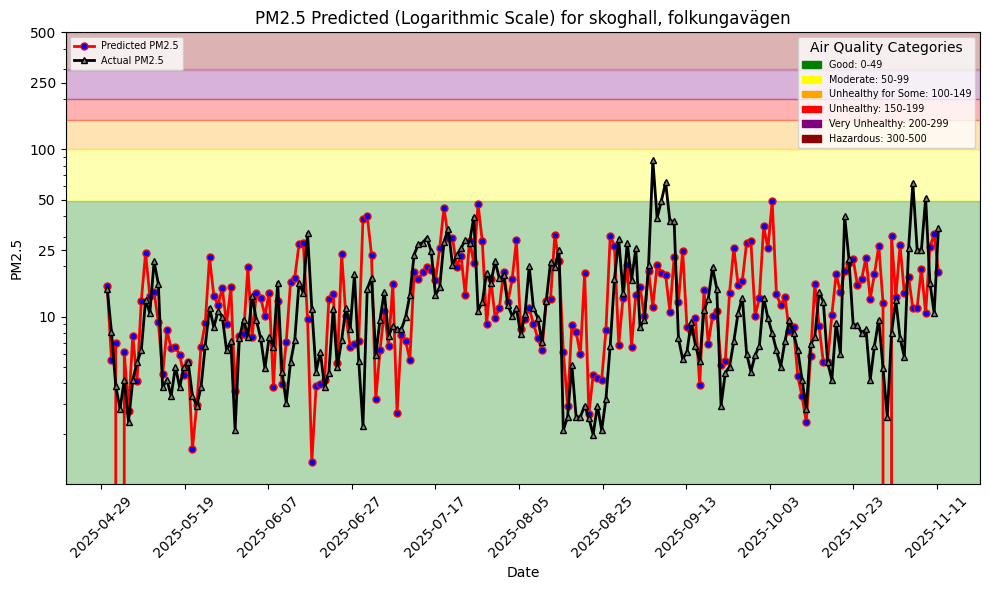

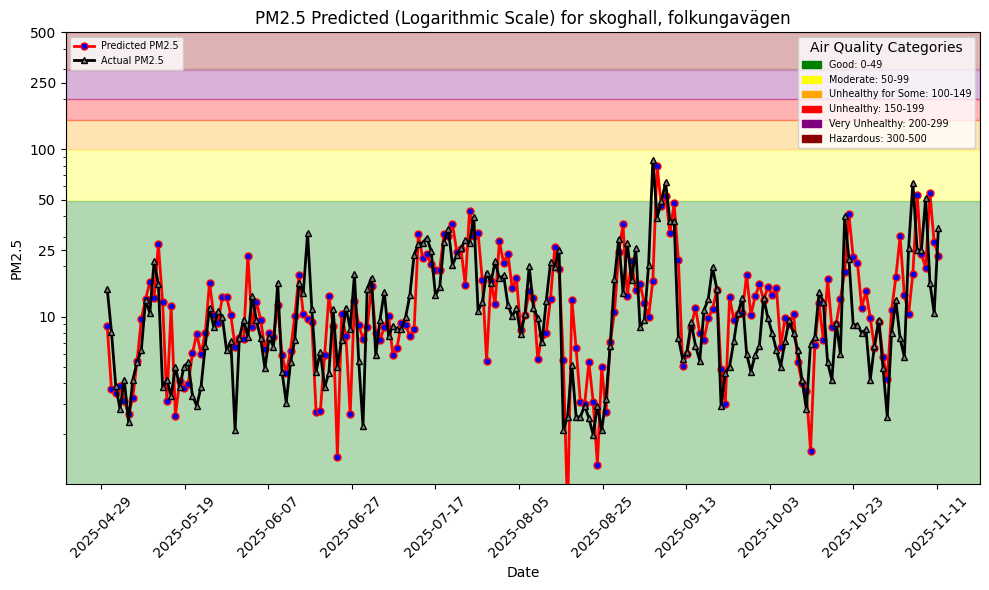

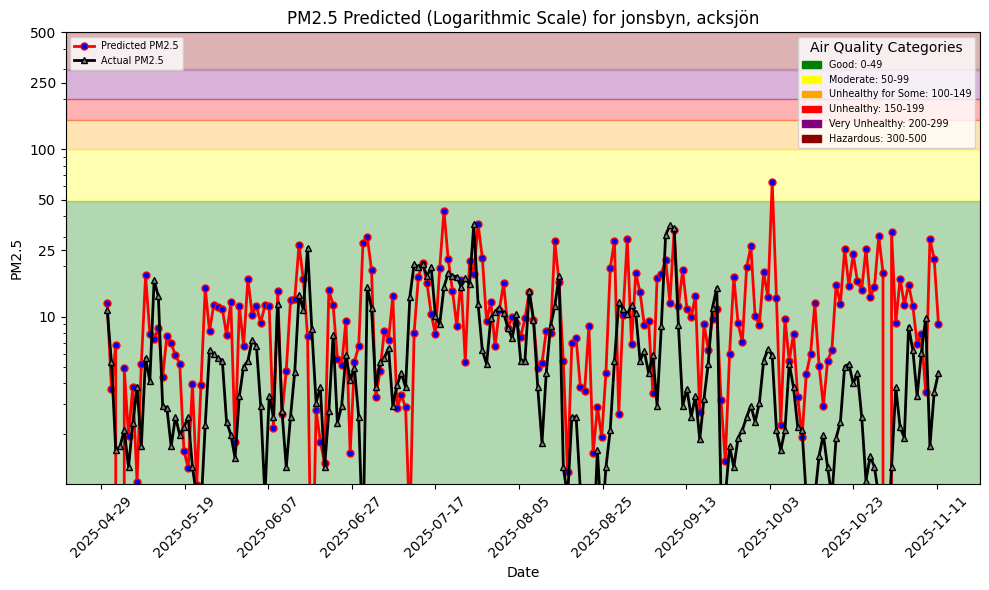

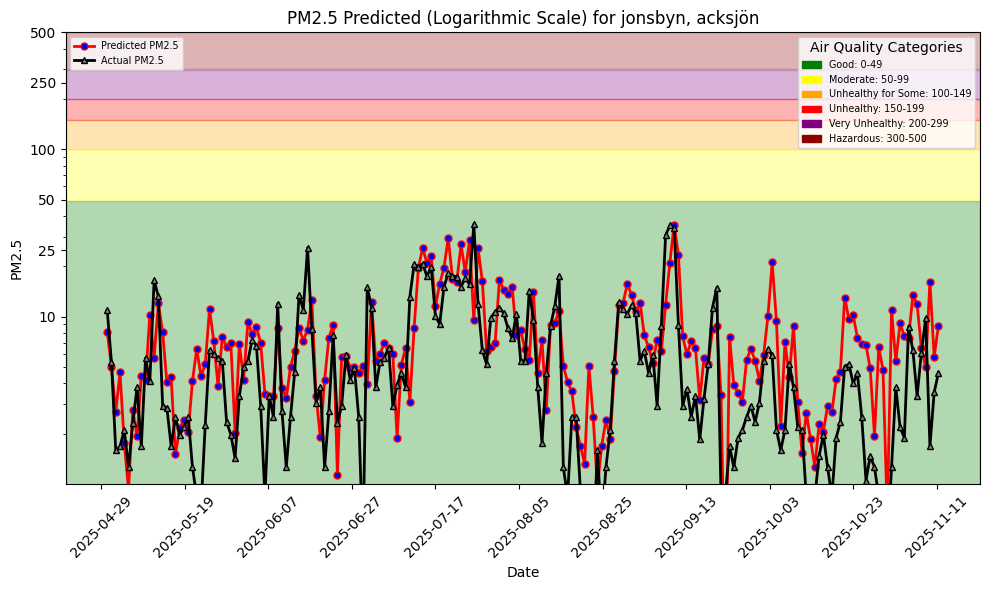

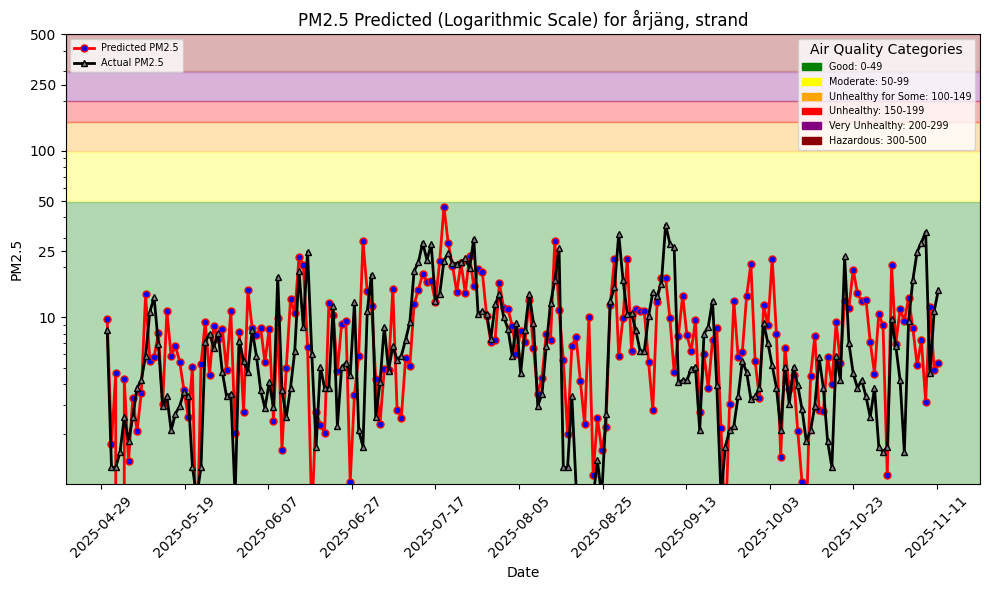

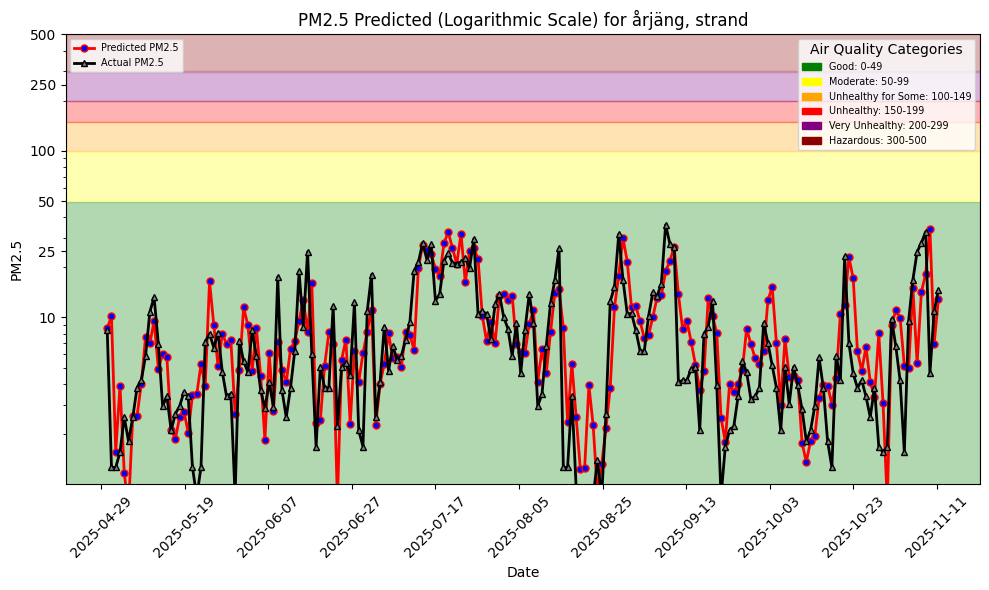

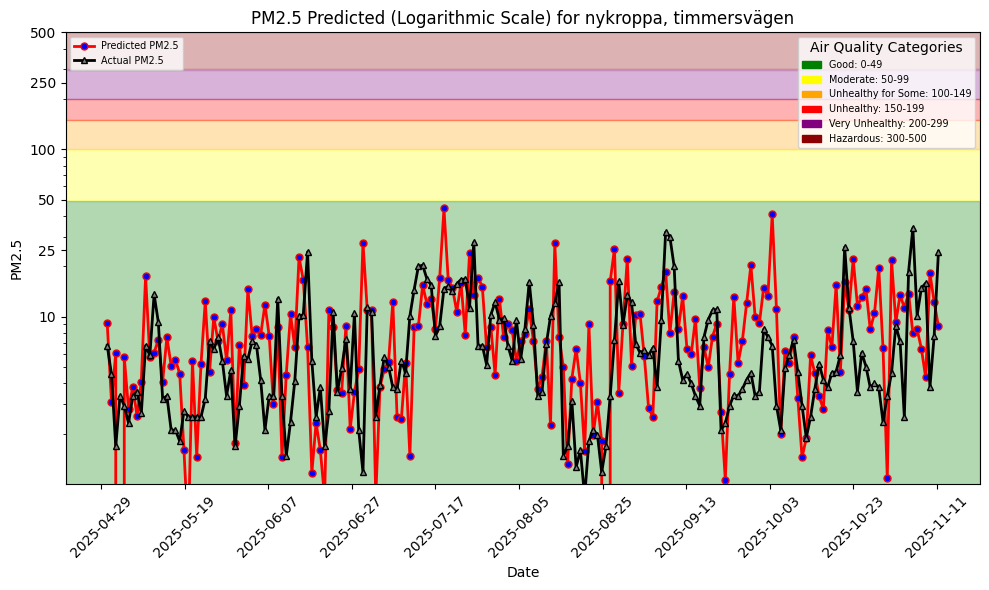

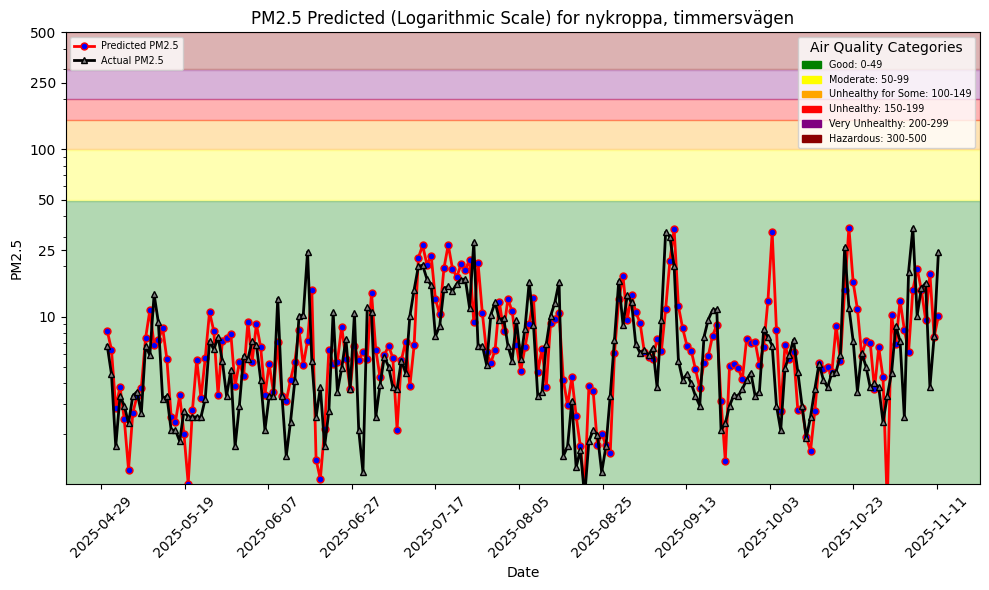

In [14]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    base_city_dir = f"{base_images_dir}/{city}"
    lagged_city_dir = f"{lagged_images_dir}/{city}"
    if not os.path.exists(base_city_dir):
        os.mkdir(base_city_dir)
    if not os.path.exists(lagged_city_dir):
        os.mkdir(lagged_city_dir)
    base_file_path = f"{base_city_dir}/pm25_hindcast.png"
    lagged_file_path = f"{lagged_city_dir}/pm25_hindcast.png"
    base_plt = util.plot_air_quality_forecast(city, street, base_df[base_df['city'] == city], base_file_path, hindcast=True) 
    lagged_plt = util.plot_air_quality_forecast(city, street, lagged_df[lagged_df['city'] == city], lagged_file_path, hindcast=True) 
    base_plt.show()
    lagged_plt.show()

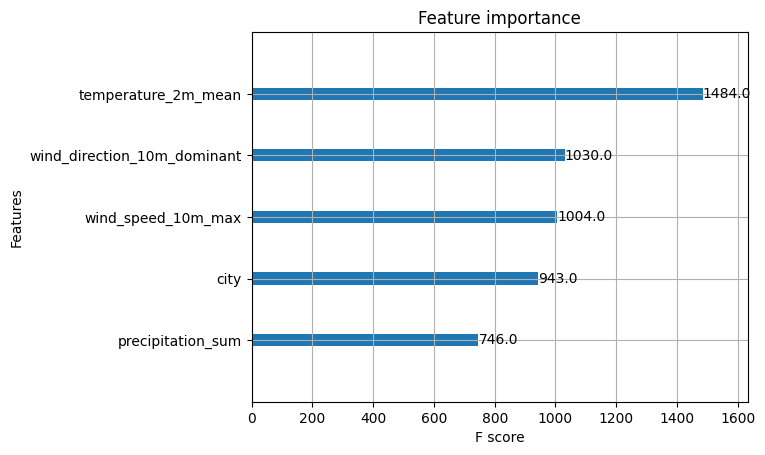

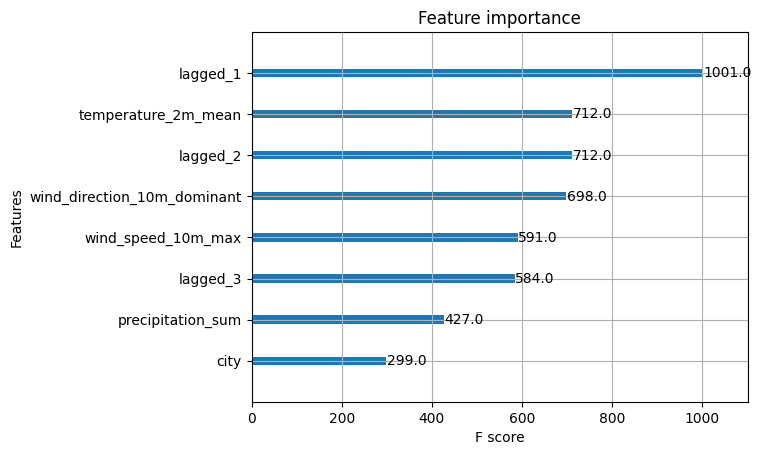

In [15]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_base_regressor)
base_feature_importance_path = base_images_dir + "/feature_importance.png"
plt.savefig(base_feature_importance_path)
plt.show()
plot_importance(xgb_lagged_regressor)
lagged_feature_importance_path = lagged_images_dir + "/feature_importance.png"
plt.savefig(lagged_feature_importance_path)
plt.show()

In [16]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_base_regressor.save_model(base_model_dir + "/model.json")
xgb_lagged_regressor.save_model(lagged_model_dir + "/model.json")

In [17]:
base_res_dict = { 
        "MSE": str(base_mse_test),
        "R squared": str(base_r2_test),
    }

lagged_res_dict = { 
        "MSE": str(lagged_mse_test),
        "R squared": str(lagged_r2_test),
    }

In [18]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

base_aq_model = mr.python.create_model(
    name="air_quality_xgboost_base_model", 
    metrics= base_res_dict,
    feature_view=base_feature_view,
    description="Air Quality (PM2.5) predictor",
)

lagged_aq_model = mr.python.create_model(
    name="air_quality_xgboost_lagged_model", 
    metrics= lagged_res_dict,
    feature_view=lagged_feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
base_aq_model.save(base_model_dir)
lagged_aq_model.save(lagged_model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/597287 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/21760 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/141493 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/146115 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/146306 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/149692 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272014/models/air_quality_xgboost_base_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/568872 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/27730 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/137428 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/137738 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138858 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138686 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272014/models/air_quality_xgboost_lagged_model/1


Model(name: 'air_quality_xgboost_lagged_model', version: 1)